# Predicting Age in Census Data<a href="#Predicting-Age-in-Census-Data" class="anchor-link"></a>

## Introduction<a href="#Introduction" class="anchor-link"></a>

The objective of this toy project is to predict the age of an individual
with the 1994 US Census Data using multiple linear regression. We use
the `Statsmodels` and `Patsy` modules for this task with Pyhon version
\>= 3.6. The dataset was sourced from the UCI Machine Learning
Repository at <https://archive.ics.uci.edu/ml/datasets/adult> (Lichman,
2013).

This report is organized as follows:

-   [Overview](#Overview) section describes the dataset used and the
    features in this dataset.
-   [Data Preparation](#Data-Preparation) section covers data cleaning
    and data preparation steps.
-   [Data Exploration](#Data-Exploration) section explores dataset
    features and their inter-relationships.
-   [Statistical Modeling and Performance
    Evaluation](#Statistical-Modeling-and-Performance-Evaluation)
    section first fits a full multiple linear regression model and
    performs diagnostic checks. Next, we perform backwards variable
    selection using p-values to obtain a reduced model, after which we
    perform another set of diagnostic checks on the reduced model.
-   [Summary and Conclusions](#Summary-and-Conclusions) section provides
    a summary of our work and presents our findings.

## Overview<a href="#Overview" class="anchor-link"></a>

### Data Source<a href="#Data-Source" class="anchor-link"></a>

The UCI Machine Learning Repository provides five datasets, but only
`adult.data`, `adult.test`, and `adult.names` were useful in this
project. The `adult.data` and `adult.test` are the training and test
datasets respectively. The `adult.names` file contains the details of
the variables (a.k.a. features or attributes). The training dataset has
32,561 observations (a.k.a. instances or records) and the test dataset
has 16,281 observations. Both datasets consist of 14 descriptive (a.k.a.
independent) features and one target (a.k.a. response or dependent)
feature. In this project, we combine both training and test data into
one.

### Project Objective<a href="#Project-Objective" class="anchor-link"></a>

Our goal is to see if we can predict an individual's age within an
acceptable margin of error using multiple linear regression primarily
with just main affects.

### Target Feature<a href="#Target-Feature" class="anchor-link"></a>

Our target feature is `age`, which is a continuous numerical feature.
Hence, our project is on a regression problem.

### Descriptive Features<a href="#Descriptive-Features" class="anchor-link"></a>

The variable descriptions below are from the `adult.names` file:

-   **`workclass`**: Private, Self-emp-not-inc, Self-emp-inc,
    Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
-   **`fnlwgt`**: continuous.
-   **`education`**: Bachelors, Some-college, 11th, HS-grad,
    Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters,
    1st-4th, 10th, Doctorate, 5th-6th, Preschool.
-   **`education-num`**: continuous.
-   **`marital-status`**: Married-civ-spouse, Divorced, Never-married,
    Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
-   **`occupation`**: Tech-support, Craft-repair, Other-service, Sales,
    Exec-managerial, Prof-specialty, Handlers-cleaners,
    Machine-op-\*inspct, Adm-clerical, Farming-fishing,
    Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
-   **`relationship`**: Wife, Own-child, Husband, Not-in-family,
    Other-relative, Unmarried.
-   **`race`**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other,
    Black.
-   **`sex`**: Female, Male.
-   **`capital-gain`**: continuous.
-   **`capital-loss`**: continuous.
-   **`hours-per-week`**: continuous.
-   **`native-country`**: United-States, Cambodia, England, Puerto-Rico,
    Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece,
    South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland,
    Jamaica, Vietnam, Mexico, Portugal, Ireland, France,
    Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary,
    Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El Salvador,
    Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
-   **`income`**: binary, 1: earns over \\$50k a year, 0: earns less
    than \\$50k a year.

Most of the descriptive features are self-explanatory, except `fnlwgt`
which stands for "Final Weight" defined by the US Census. This weight is
an "estimate of the number of units in the target population that the
responding unit represents" (Lichman, 2013). This feature aims to
allocate similar weights to people with similar demographic
characteristics.

## Data Preparation<a href="#Data-Preparation" class="anchor-link"></a>

### Preliminaries<a href="#Preliminaries" class="anchor-link"></a>

For further information on how to prepare your data for statistical modeling, please refer to [this page](https://www.featureranking.com/tutorials/machine-learning-tutorials/data-preparation-for-machine-learning/)
on our website.

First, let's import all the common modules we will be using.

In [2]:
# Importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import warnings
from IPython.display import display, HTML
from ipywidgets import interactive
def function_mcq(selection): pass
###
warnings.filterwarnings('ignore')
###
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

We read the training and test datasets directly from the data URLs.
Also, since the datasets do not contain the attribute names, they are
explicitly specified during data loading process. The `adultData`
dataset is read first and then it is concatenated with `adultTest` as
just `data`.

In [3]:
# Read in data
df = pd.read_csv("https://raw.githubusercontent.com/BenRyc/SPACE-/main/orbitDistNoLim.csv")

# Display randomly selected 10 rows
df.sample(10, random_state=999)

,sy_snum,sy_pnum,discoverymethod,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_rade,...,st_age,st_ageerr1,st_ageerr2,st_agelim,st_dens,st_denserr1,st_denserr2,sy_dist,sy_disterr1,sy_disterr2
443,2,3,Transit,6.922600,0.000700,-0.000700,0.061600,0.001900,-0.001900,1.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.45800,0.626000,-0.619000
1436,1,2,Transit,13.297004,0.000185,-0.000185,0.093000,NaN,NaN,0.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1126,1,2,Transit,41.008011,0.000191,-0.000191,0.216000,NaN,NaN,2.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,510.52300,6.170000,-6.027000
1835,3,1,Radial Velocity,1257.253027,5.956519,-6.187601,2.248182,0.089047,-0.095341,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.09610,0.245300,-0.243600
49,2,6,Radial Velocity,34.940000,0.038000,-0.035000,0.205500,0.002200,-0.002100,NaN,...,7.6,3.7,-3.7,0.0,NaN,NaN,NaN,282.56300,1.776000,-1.753000
1848,1,1,Radial Velocity,4540.000000,160.000000,-140.000000,5.130000,0.120000,-0.110000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.87400,0.244800,-0.242300
1646,1,1,Radial Velocity,17281.665140,4832.845024,-3919.179915,10.121898,1.858612,-1.682453,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.67315,0.005135,-0.005135
1523,1,2,Radial Velocity,421.000000,2.000000,-2.000000,1.070000,0.030000,-0.030000,NaN,...,NaN,NaN,NaN,NaN,1.99,0.07,-0.07,163.37100,1.067000,-1.052000
1410,1,2,Transit,67.968015,0.001070,-0.001070,0.313000,NaN,NaN,1.78,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,813.19200,12.422500,-12.422500
1956,1,1,Radial Velocity,673.200000,3.300000,-3.300000,1.740000,0.330000,-0.330000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.19200,1.963000,-1.963000


### Data Cleaning and Transformation<a href="#Data-Cleaning-and-Transformation" class="anchor-link"></a>

We first confirm that the feature types match the descriptions outlined
in the documentation.

In [4]:
print(f"Shape of the dataset is {df.shape} \n")
print(f"Data types are below where 'object' indicates a string type: ")
print(df.dtypes)

Shape of the dataset is (2728, 55) 

Data types are below where 'object' indicates a string type: 
sy_snum              int64
sy_pnum              int64
discoverymethod     object
pl_orbper          float64
pl_orbpererr1      float64
pl_orbpererr2      float64
pl_orbsmax         float64
pl_orbsmaxerr1     float64
pl_orbsmaxerr2     float64
pl_rade            float64
pl_radeerr1        float64
pl_radeerr2        float64
pl_masse           float64
pl_masseerr1       float64
pl_masseerr2       float64
pl_dens            float64
pl_denserr1        float64
pl_denserr2        float64
pl_orbeccen        float64
pl_orbeccenerr1    float64
pl_orbeccenerr2    float64
pl_insol           float64
pl_insolerr1       float64
pl_insolerr2       float64
pl_eqt             float64
pl_eqterr1         float64
pl_eqterr2         float64
pl_eqtlim          float64
st_spectype         object
st_teff            float64
st_tefferr1        float64
st_tefferr2        float64
st_rad             float64
st_raderr1

### Cleaning outlighers and missing values

In [46]:
rad = df.dropna(subset=['pl_rade', 'pl_radeerr1', 'pl_radeerr2'])
mass = df.dropna(subset=['pl_masse', 'pl_masseerr1', 'pl_masseerr2'])
dens = df.dropna(subset=['pl_dens', 'pl_denserr1', 'pl_denserr2'])
orbeccen = df.dropna(subset=['pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2'])
insol = df.dropna(subset=['pl_insol', 'pl_insolerr1', 'pl_insolerr2'])
eqt = df.dropna(subset=['pl_eqt', 'pl_eqterr1', 'pl_eqterr2'])
teff = df.dropna(subset=['st_teff', 'st_tefferr1', 'st_tefferr2'])
radst = df.dropna(subset=['st_rad', 'st_raderr1', 'st_raderr2'])
massst = df.dropna(subset=['st_mass', 'st_masserr1', 'st_masserr2'])
met = df.dropna(subset=['st_met', 'st_meterr1', 'st_meterr2'])
agest = df.dropna(subset=['st_age', 'st_ageerr1', 'st_ageerr2'])

# 3 verables 

massDens = df.dropna(subset=['pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_dens', 'pl_denserr1', 'pl_denserr2'])
insolEqt = df.dropna(subset=['pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2'])
massstMet = df.dropna(subset=['st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2'])
supe = df.dropna(subset=['pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2'])
supe1 = df.dropna(subset=['pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2'])

rad = rad[['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
mass = mass[['pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
dens = dens[['pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
orbeccen = orbeccen[['pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
insol = insol[['pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
eqt = eqt[['pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
teff = teff[['st_teff', 'st_tefferr1', 'st_tefferr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
radst = radst[['st_rad', 'st_raderr1', 'st_raderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
massst = massst[['st_mass', 'st_masserr1', 'st_masserr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
met = met[['st_met', 'st_meterr1', 'st_meterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
agest = agest[['st_age', 'st_ageerr1', 'st_ageerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]

# 3 verable 
massDens = massDens[['pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
insolEqt = insolEqt[['pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
massstMet = massstMet[['st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
supe = supe[['pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
supe1 = supe1[['pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_met', 'st_meterr1', 'st_meterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]

rad = rad[~((rad < (rad.quantile(0.25) - 1.5 * (rad.quantile(0.75) - rad.quantile(0.25)))) |(rad > (rad.quantile(0.75) + 1.5 * (rad.quantile(0.75) - rad.quantile(0.25))))).any(axis=1)]
mass = mass[~((mass < (mass.quantile(0.25) - 1.5 * (mass.quantile(0.75) - mass.quantile(0.25)))) |(mass > (mass.quantile(0.75) + 1.5 * (mass.quantile(0.75) - mass.quantile(0.25))))).any(axis=1)]
dens = dens[~((dens < (dens.quantile(0.25) - 1.5 * (dens.quantile(0.75) - dens.quantile(0.25)))) |(dens > (dens.quantile(0.75) + 1.5 * (dens.quantile(0.75) - dens.quantile(0.25))))).any(axis=1)]
orbeccen = orbeccen[~((orbeccen < (orbeccen.quantile(0.25) - 1.5 * (orbeccen.quantile(0.75) - orbeccen.quantile(0.25)))) |(orbeccen > (orbeccen.quantile(0.75) + 1.5 * (orbeccen.quantile(0.75) - orbeccen.quantile(0.25))))).any(axis=1)]
insol = insol[~((insol < (insol.quantile(0.25) - 1.5 * (insol.quantile(0.75) - insol.quantile(0.25)))) |(insol > (insol.quantile(0.75) + 1.5 * (insol.quantile(0.75) - insol.quantile(0.25))))).any(axis=1)]
eqt = eqt[~((eqt < (eqt.quantile(0.25) - 1.5 * (eqt.quantile(0.75) - eqt.quantile(0.25)))) |(eqt > (eqt.quantile(0.75) + 1.5 * (eqt.quantile(0.75) - eqt.quantile(0.25))))).any(axis=1)]
teff = teff[~((teff < (teff.quantile(0.25) - 1.5 * (teff.quantile(0.75) - teff.quantile(0.25)))) |(teff > (teff.quantile(0.75) + 1.5 * (teff.quantile(0.75) - teff.quantile(0.25))))).any(axis=1)]
radst = radst[~((radst < (radst.quantile(0.25) - 1.5 * (radst.quantile(0.75) - radst.quantile(0.25)))) |(radst > (radst.quantile(0.75) + 1.5 * (radst.quantile(0.75) - radst.quantile(0.25))))).any(axis=1)]
massst = massst[~((massst < (massst.quantile(0.25) - 1.5 * (massst.quantile(0.75) - massst.quantile(0.25)))) |(massst > (massst.quantile(0.75) + 1.5 * (massst.quantile(0.75) - massst.quantile(0.25))))).any(axis=1)]
met = met[~((met < (met.quantile(0.25) - 1.5 * (met.quantile(0.75) - met.quantile(0.25)))) |(met > (met.quantile(0.75) + 1.5 * (met.quantile(0.75) - met.quantile(0.25))))).any(axis=1)]
agest = agest[~((agest < (agest.quantile(0.25) - 1.5 * (agest.quantile(0.75) - agest.quantile(0.25)))) |(agest > (agest.quantile(0.75) + 1.5 * (agest.quantile(0.75) - agest.quantile(0.25))))).any(axis=1)]

# 3 verables
massDens = massDens[~((massDens < (massDens.quantile(0.25) - 1.5 * (massDens.quantile(0.75) - massDens.quantile(0.25)))) |(massDens > (massDens.quantile(0.75) + 1.5 * (massDens.quantile(0.75) - massDens.quantile(0.25))))).any(axis=1)]
insolEqt = insolEqt[~((insolEqt < (insolEqt.quantile(0.25) - 1.5 * (insolEqt.quantile(0.75) - insolEqt.quantile(0.25)))) |(insolEqt > (insolEqt.quantile(0.75) + 1.5 * (insolEqt.quantile(0.75) - insolEqt.quantile(0.25))))).any(axis=1)]
massstMet = massstMet[~((massstMet < (massstMet.quantile(0.25) - 1.5 * (massstMet.quantile(0.75) - massstMet.quantile(0.25)))) |(massstMet > (massstMet.quantile(0.75) + 1.5 * (massstMet.quantile(0.75) - massstMet.quantile(0.25))))).any(axis=1)]

supe = supe[~((supe < (supe.quantile(0.25) - 1.5 * (supe.quantile(0.75) - supe.quantile(0.25)))) |(supe > (supe.quantile(0.75) + 1.5 * (supe.quantile(0.75) - supe.quantile(0.25))))).any(axis=1)]
supe1 = supe1[~((supe1 < (supe1.quantile(0.25) - 1.5 * (supe1.quantile(0.75) - supe1.quantile(0.25)))) |(supe1 > (supe1.quantile(0.75) + 1.5 * (supe1.quantile(0.75) - supe1.quantile(0.25))))).any(axis=1)]


data = {}
data['rad'] = rad
data['mass'] = mass
data['dens'] = dens
data['orbeccen'] = orbeccen
data['insol'] = insol
data['eqt'] = eqt
data['teff'] = teff
data['radst'] = radst
data['massst'] = massst
data['met'] = met
data['agest'] = agest
data['massDens'] = massDens
data['insolEqt'] = insolEqt
data['massstMet'] = massstMet
data['supe'] = supe
data['supe1'] = supe1

### Summary Statistics

Select the dataset and then look at the sumery

In [5]:
sec1 = interactive(function_mcq, 
                 selection=['rad', 
                            'mass',
                            'dens',
                            'orbeccen',
                            'insol',
                            'eqt',
                            'teff',
                            'radst',
                            'massst',
                            'met',
                            'agest',
                            'massDens',
                            'insolEqt',
                            'massstMet']); 
display(sec1)

interactive(children=(Dropdown(description='selection', options=('rad', 'mass', 'dens', 'orbeccen', 'insol', '…

In [7]:
display(HTML(f'<b>Summary of features: {sec1.kwargs["selection"]}</b>'))
data[sec1.kwargs['selection']].describe()

,st_teff,st_tefferr1,st_tefferr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2
count,1664.000000,1664.000000,1664.000000,1664.000000,1.664000e+03,1.664000e+03,1664.000000,1010.000000,1010.000000
mean,5277.778648,104.096773,-103.691244,12.420207,4.617072e-04,-4.660977e-04,0.090562,0.001921,-0.002094
std,844.514706,54.088985,54.079939,14.669076,1.148378e-03,1.159837e-03,0.068919,0.002655,0.003206
min,3130.000000,3.000000,-226.000000,0.321962,2.000000e-08,-8.150000e-03,0.006400,0.000000,-0.023900
25%,4841.000000,62.000000,-132.250000,3.633650,1.000000e-05,-3.000000e-04,0.045187,0.000530,-0.002080
50%,5519.000000,100.000000,-100.000000,7.058410,5.500000e-05,-5.400000e-05,0.068000,0.001000,-0.001000
75%,5901.000000,132.250000,-61.000000,14.991510,3.000000e-04,-1.000000e-05,0.115000,0.002000,-0.000540
max,7500.000000,226.000000,-3.000000,96.101141,8.150000e-03,-2.000000e-08,0.466900,0.023000,0.000000


## Data Exploration<a href="#Data-Exploration" class="anchor-link"></a>

Our dataset can now be considered "clean" and ready for visualisation
and statistical modeling.

### Univariate Visualisation<a href="#Univariate-Visualisation" class="anchor-link"></a>

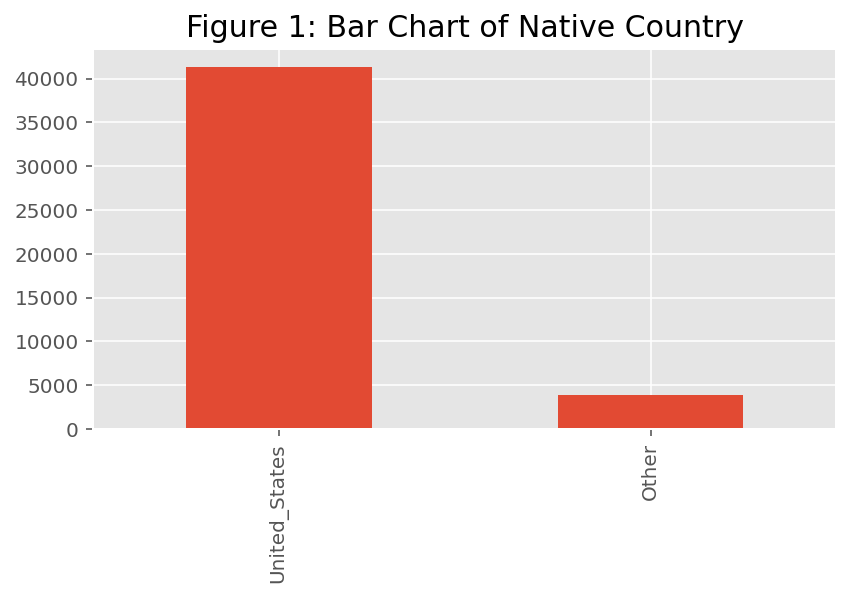

In [18]:
ax = data['native_country'].value_counts().plot(kind = 'bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.tight_layout()
plt.title('Figure 1: Bar Chart of Native Country', fontsize = 15)
plt.show();

Let's display a boxplot and histogram for `age`. Figure 2 shows that
this variable is right-skewed.

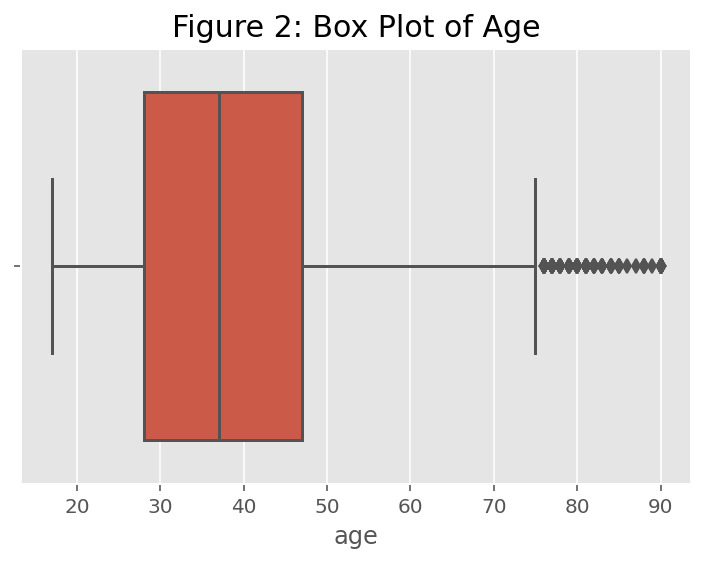

In [19]:
# get a box plot of age
sns.boxplot(data['age']).set_title('Figure 2: Box Plot of Age', fontsize = 15)
plt.show();

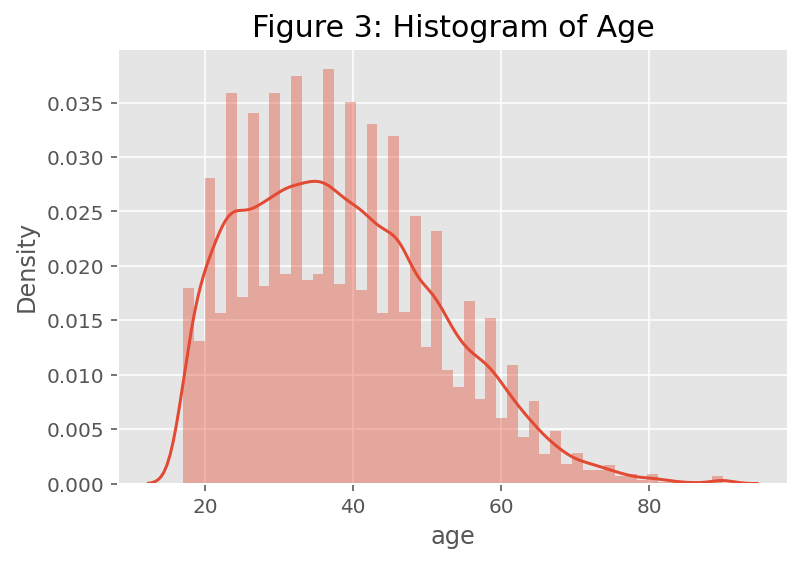

In [20]:
# get a histogram of age with kernel density estimate
sns.distplot(data['age'], kde = True).set_title('Figure 3: Histogram of Age', fontsize = 15)
plt.show();

### Multivariate Visualisation<a href="#Multivariate-Visualisation" class="anchor-link"></a>

#### Scatterplot of Numeric Features and Age<a href="#Scatterplot-of-Numeric-Features-and-Age" class="anchor-link"></a>

The scatterplot in Figure 4 shows no clear correlation between the age
and hours_per_week numeric variables.

In [8]:
sec2 = interactive(function_mcq, 
                 selection=['rad', 
                            'mass',
                            'dens',
                            'orbeccen',
                            'insol',
                            'eqt',
                            'teff',
                            'radst',
                            'massst',
                            'met',
                            'agest']); 
display(sec2)

interactive(children=(Dropdown(description='selection', options=('rad', 'mass', 'dens', 'orbeccen', 'insol', '…

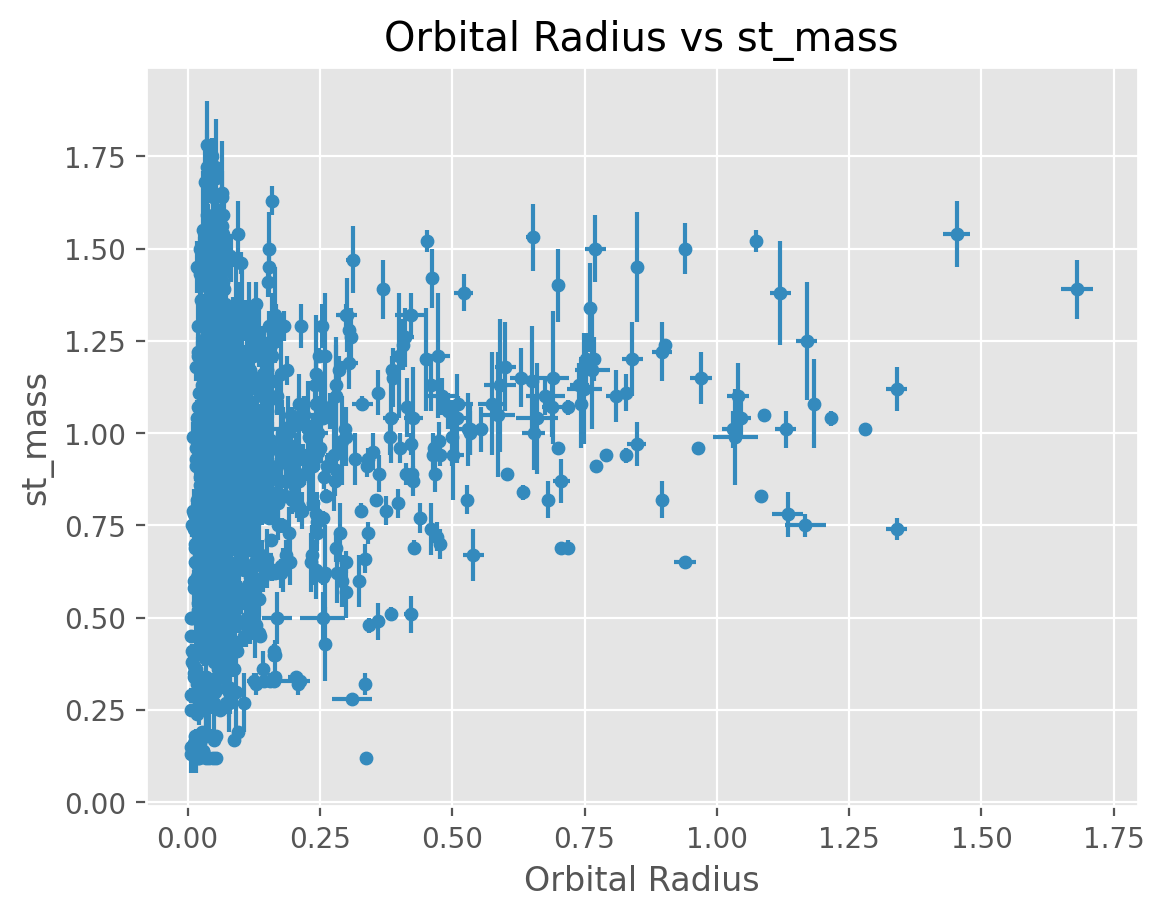

In [10]:
if sec2.kwargs['selection'] == 'teff':
    indv = 'st_teff'
elif sec2.kwargs['selection'] == 'radst':
    indv = 'st_rad'
elif sec2.kwargs['selection'] == 'massst':
    indv = 'st_mass'
elif sec2.kwargs['selection'] == 'met':
    indv = 'st_met'
elif sec2.kwargs['selection'] == 'agest':
    indv = 'st_age'
elif sec2.kwargs['selection'] == 'rad':
    indv = 'pl_rade'
elif sec2.kwargs['selection'] == 'mass':
    indv = 'pl_masse'
else:
    indv = 'pl_' + sec2.kwargs['selection']

data[sec2.kwargs['selection']].plot(kind = 'scatter', 
         x = 'pl_orbsmax', 
         y = indv, 
         xerr=data[sec2.kwargs['selection']]['pl_orbsmaxerr1'], 
         yerr=data[sec2.kwargs['selection']][indv + 'err1'],
         ylabel= indv,
         xlabel= 'Orbital Radius',
         title='Orbital Radius vs '+ indv)

plt.show()

In [3]:
sec3 = interactive(function_mcq, 
                 selection=['massDens',
                            'insolEqt',
                            'massstMet']); 
display(sec3)

NameError: name 'interactive' is not defined

In [4]:
if sec3.kwargs['selection'] == 'massDens':
    indv1 = 'pl_masse'
    indv2 = 'pl_dens'
elif sec3.kwargs['selection'] == 'insolEqt':
    indv1 = 'pl_insol'
    indv2 = 'pl_eqt'
elif sec3.kwargs['selection'] == 'massstMet':
    indv1 = 'st_mass'
    indv2 = 'st_met'

plt.scatter( 
         x = data[sec3.kwargs['selection']]['pl_orbsmax'], 
         y = data[sec3.kwargs['selection']][indv1],
         s = data[sec3.kwargs['selection']][indv2],)
print( f'orbit radius vs {indv1} with {indv2} as size')
plt.show()

NameError: name 'sec3' is not defined

## Statistical Modeling and Performance Evaluation<a href="#Statistical-Modeling-and-Performance-Evaluation" class="anchor-link"></a>

### Full Model<a href="#Full-Model" class="anchor-link"></a>

We begin by fitting a multiple linear regression that predicts `age`
using all of the available features. We call this the full model. First
let's take a quick peak at the clean data.

In [65]:
# short and sweet
dataString = {}

for key, value in data.items():
    if key == 'teff':
        dataString[key] = 'pl_orbsmax ~ ' + 'st_teff'
    elif key == 'radst':
        dataString[key] = 'pl_orbsmax ~ ' + 'st_rad'
    elif key == 'massst':
        dataString[key] = 'pl_orbsmax ~ ' + 'st_mass'
    elif key == 'met':
        dataString[key] = 'pl_orbsmax ~ ' + 'st_met'
    elif key == 'agest':
        dataString[key] = 'pl_orbsmax ~ ' + 'st_age'
    elif key == 'rad':
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_rade'
    elif key == 'mass':
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_masse'
    elif key == 'massDens':
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_masse' + ' + pl_dens'
    elif key == 'insolEqt':
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_insol ' + '+ pl_eqt'
    elif key == 'massstMet':
        dataString[key] = 'pl_orbsmax ~ ' + 'st_mass ' + '+ st_met'
    elif key == 'supe':
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_masse ' +  '+ pl_rade ' + '+ pl_insol ' + '+ pl_eqt ' + '+ st_mass ' + '+ st_met '
    elif key == 'supe1':
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_dens ' + '+ pl_masse ' + '+ pl_rade ' + '+ pl_orbeccen ' + '+ st_mass ' + '+ st_met'
    else:
        dataString[key] = 'pl_orbsmax ~ ' + 'pl_' + key
    print(dataString[key])

pl_orbsmax ~ pl_rade
pl_orbsmax ~ pl_masse
pl_orbsmax ~ pl_dens
pl_orbsmax ~ pl_orbeccen
pl_orbsmax ~ pl_insol
pl_orbsmax ~ pl_eqt
pl_orbsmax ~ st_teff
pl_orbsmax ~ st_rad
pl_orbsmax ~ st_mass
pl_orbsmax ~ st_met
pl_orbsmax ~ st_age
pl_orbsmax ~ pl_masse + pl_dens
pl_orbsmax ~ pl_insol + pl_eqt
pl_orbsmax ~ st_mass + st_met
pl_orbsmax ~ pl_masse + pl_rade + pl_insol + pl_eqt + st_mass + st_met 
pl_orbsmax ~ pl_dens + pl_masse + pl_rade + pl_orbeccen + st_mass + st_met


Now that we have defined our statistical model formula as a Python
string, we fit an OLS (ordinary least squares) model to our encoded
data.

In [48]:
models = {}

for key in data.keys():
    models[key] = sm.formula.ols(formula=dataString[key], data=data[key])
    models[key] = models[key].fit()
    print(models[key].summary())

                            OLS Regression Results                            
Dep. Variable:             pl_orbsmax   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     97.10
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           4.21e-22
Time:                        15:59:22   Log-Likelihood:                 2083.1
No. Observations:                1235   AIC:                            -4162.
Df Residuals:                    1233   BIC:                            -4152.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0871      0.002     48.523      0.0

The full model has an adjusted R-squared value of 0.405, which means
that only 40% of the variance is explained by the model. By looking at
the p-values, we observe that the majority of them are highly
significant, though there are a few insignificant variables at a 5%
level.

Let's define a new data frame for actual age vs. predicted age and the
residuals for the full model. We will use this data frame when plotting
predicted values and the regression residuals.

In [51]:
pred = {}
for key in data.keys():
    pred[key] = pd.DataFrame({'actual': data[key]['pl_orbsmax'], 
                               'predicted': models[key].fittedvalues, 
                               'residual': models[key].resid})


Let's plot actual age values vs. predicted values.

From Figure 9, we observe that the model never produces a prediction
above 80 even though the oldest person in the dataset is 90.

We will now check the diagnostics for the full model.

### Full Model Diagnostic Checks<a href="#Full-Model-Diagnostic-Checks" class="anchor-link"></a>

We would like to check whether there are indications of violations of
the regression assumptions, which are

1.  linearity of the relationship between target variable and the
    independent variables
2.  constant variance of the errors
3.  normality of the residual distribution
4.  statistical independence of the residuals

Let's first get a scatter plot of residuals (as a function of predicted
`age`).

In [49]:
sec4 = interactive(function_mcq, 
                 selection=['rad', 
                            'mass',
                            'dens',
                            'orbeccen',
                            'insol',
                            'eqt',
                            'teff',
                            'radst',
                            'massst',
                            'met',
                            'agest',
                            'massDens',
                            'insolEqt',
                            'massstMet',
                            'supe',
                            'supe1']); 
display(sec4)

interactive(children=(Dropdown(description='selection', options=('rad', 'mass', 'dens', 'orbeccen', 'insol', '…

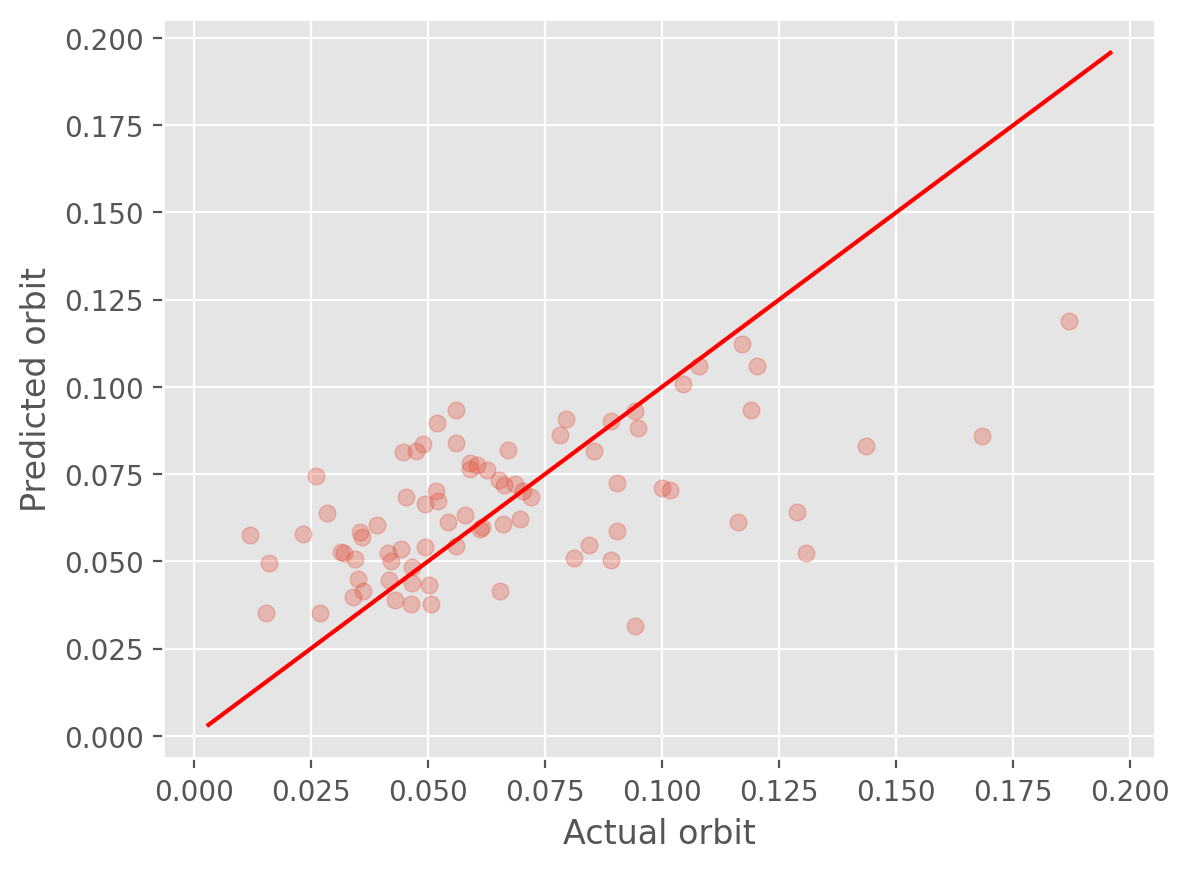

In [52]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)

plt.scatter(pred[sec4.kwargs['selection']]['actual'], pred[sec4.kwargs['selection']]['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual orbit');
plt.ylabel('Predicted orbit');

plt.show()

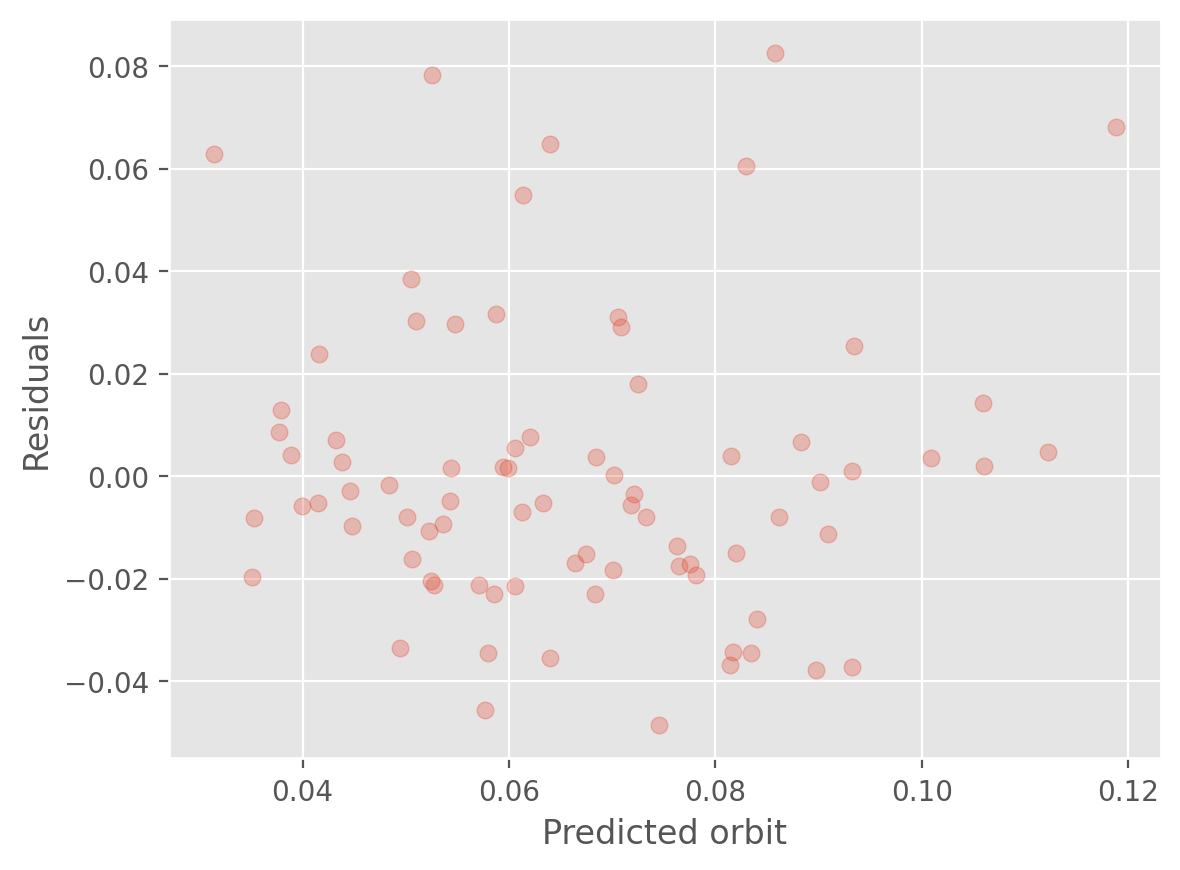

In [53]:
plt.scatter(pred[sec4.kwargs['selection']]['predicted'], pred[sec4.kwargs['selection']]['residual'], alpha=0.3);
plt.xlabel('Predicted orbit');
plt.ylabel('Residuals')
plt.show();

From Figure 10(a), we see that, rather than being mostly random and
centered around 0, the residuals exhibit a banding pattern, especially
when predicted age is below 50. This pattern indicates that the constant
variability assumption of linear regression is not quite satisfied in
this case.

Let's now plot actual age vs. residuals.

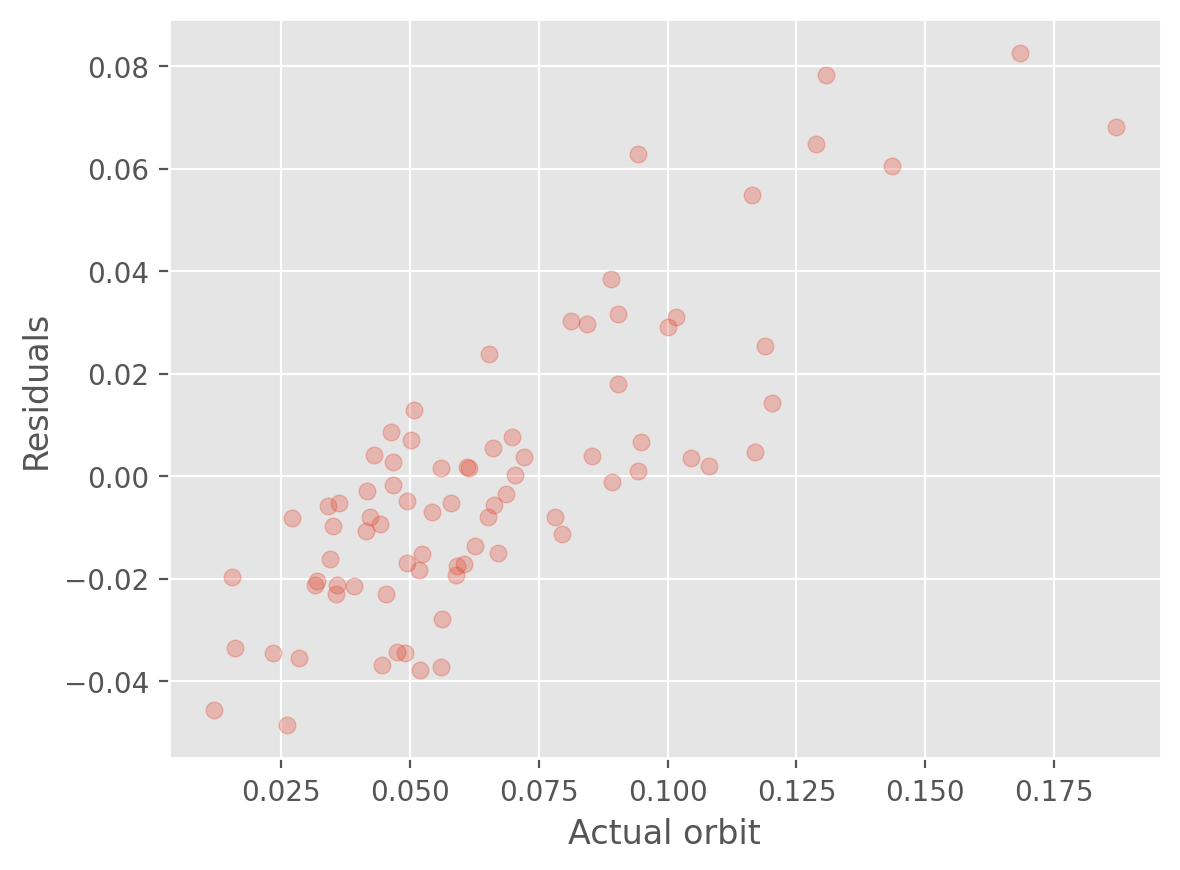

In [54]:
plt.scatter(pred[sec4.kwargs['selection']]['actual'], pred[sec4.kwargs['selection']]['residual'], alpha=0.3);
plt.xlabel('Actual orbit');
plt.ylabel('Residuals')
plt.show();

We notice that the model overestimates younger ages and underestimates
older ages. In particular, for those younger than the age of 30, the
model predicts much older ages. Also, for those above the age of 80, the
model predicts significantly younger ages.

Let's overlay the histograms of actual vs. predicted age on the same
plot.

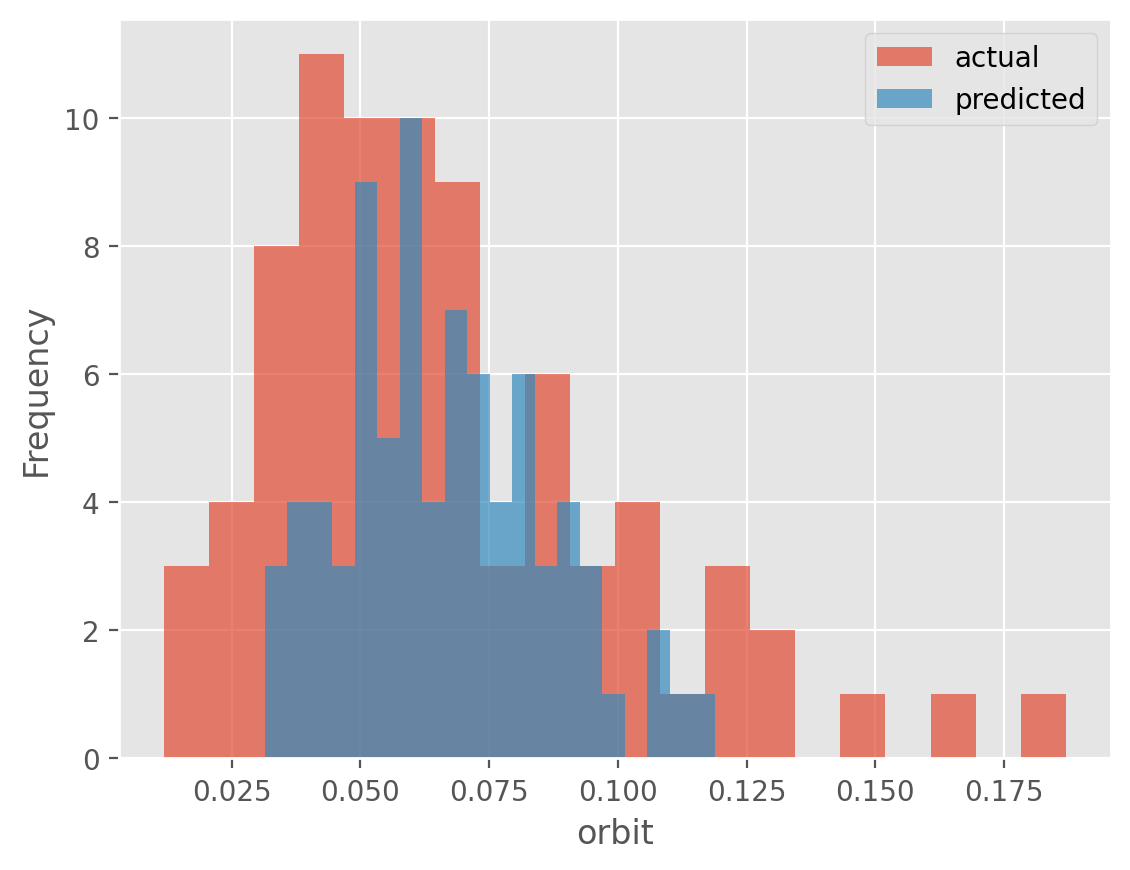

In [55]:
plt.hist(pred[sec4.kwargs['selection']]['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(pred[sec4.kwargs['selection']]['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('orbit');
plt.ylabel('Frequency');
plt.legend()
plt.show();

We notice that their distributions are quite different. In particular,
the model's predictions are highly clustered around mid-40's.

Let's now have look at the histogram of the residuals.

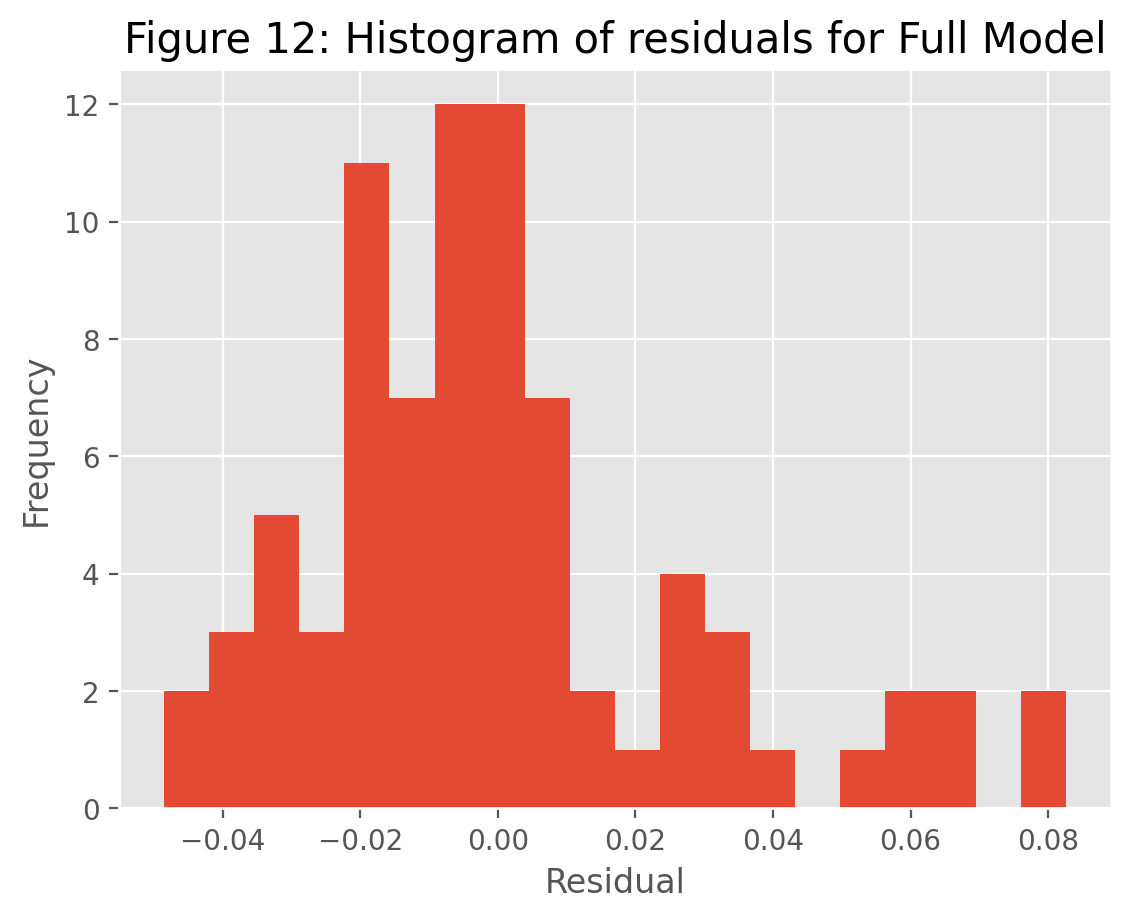

In [56]:
plt.hist(pred[sec4.kwargs['selection']]['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

From Figure 12, the histogram of residuals looks somewhat symmetric,
though slightly right-skewed. Nonetheless, it seems the normality
assumption of linear regression is not significantly violated in this
particular case.

### Backwards Feature Selection<a href="#Backwards-Feature-Selection" class="anchor-link"></a>

We now perform backwards feature selection using p-values. It appears
`Statsmodels` does not have any canned code for automatic feature
selection, so we wrote one ourselves.

In [63]:
sec5 = interactive(function_mcq, 
                 selection=['supe',
                            'supe1']); 
display(sec5)

interactive(children=(Dropdown(description='selection', options=('supe', 'supe1'), value='supe'), Output()), _…

In [67]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(dataString[sec5.kwargs['selection']])

# initialize feature-selected fit to full model
linreg_fit = models[sec5.kwargs['selection']]

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    

    linreg_fit = smf.ols(formula=patsy_description, data=data[sec5.kwargs['selection']]).fit()

###
## this is the clean fit after backwards elimination
models[sec5] = smf.ols(formula = patsy_description, data = data[sec5.kwargs['selection']]).fit()
###

#########
print("\n***")
print(models[sec5.kwargs['selection']].summary())
print("***")
print(f"Regression number of terms: {len(models[sec5.kwargs['selection']].model.exog_names)}")
print(f"Regression F-distribution p-value: {models[sec5.kwargs['selection']].f_pvalue:.4f}")
print(f"Regression R-squared: {models[sec5.kwargs['selection']].rsquared:.4f}")
print(f"Regression Adjusted R-squared: {models[sec5.kwargs['selection']].rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "pl_orbeccen" with p-value 0.5963

Removing term "pl_masse" with p-value 0.3214

***
                            OLS Regression Results                            
Dep. Variable:             pl_orbsmax   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     5.805
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           5.51e-05
Time:                        16:10:04   Log-Likelihood:                 172.50
No. Observations:                  80   AIC:                            -331.0
Df Residuals:                      73   BIC:                            -314.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t

Similar to what we did for the full model, let's define a new data frame
for actual age vs. predicted age and the residuals for the reduced
model.

In [69]:
pred[sec5.kwargs['selection']] = pd.DataFrame({'actual': data[sec5.kwargs['selection']]['pl_orbsmax'], 
                                  'predicted': models[sec5.kwargs['selection']].fittedvalues, 
                                  'residual': models[sec5.kwargs['selection']].resid})
pred[sec5.kwargs['selection']].head(10)

,actual,predicted,residual
21,0.06530,0.041564,0.023736
33,0.04461,0.081414,-0.036804
34,0.05893,0.078154,-0.019224
35,0.07820,0.086190,-0.007990
36,0.10447,0.100907,0.003563
44,0.04630,0.037734,0.008566
45,0.09490,0.088312,0.006588
64,0.01544,0.035112,-0.019672
205,0.07950,0.090904,-0.011404
215,0.16840,0.085814,0.082586


In [2]:
# get a scatter plot
plt.scatter(pred[sec5.kwargs['selection']]['actual'], pred[sec5.kwargs['selection']]['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Age');
plt.ylabel('Predicted Age');
plt.title('Figure 13: Scatter plot of actual vs. predicted age for Reduced Model', fontsize=15);
plt.show(); 

NameError: name 'plt' is not defined

This model returns an Adjusted R-squared of 0.404, meaning the reduced
model still explains about 40% of the variance, but with 6 less
variables. Looking at the p-values, they are all significant at the 5%
level, as expected. From Figure 13, we still have the same issues with
our model. That is, the model overestimates younger ages and
underestimates older ages. We will now perform the diagnostic checks on
this reduced model.

### Reduced Model Diagnostic Checks<a href="#Reduced-Model-Diagnostic-Checks" class="anchor-link"></a>

Let's first get a scatter plot of residuals (as a function of predicted
age).

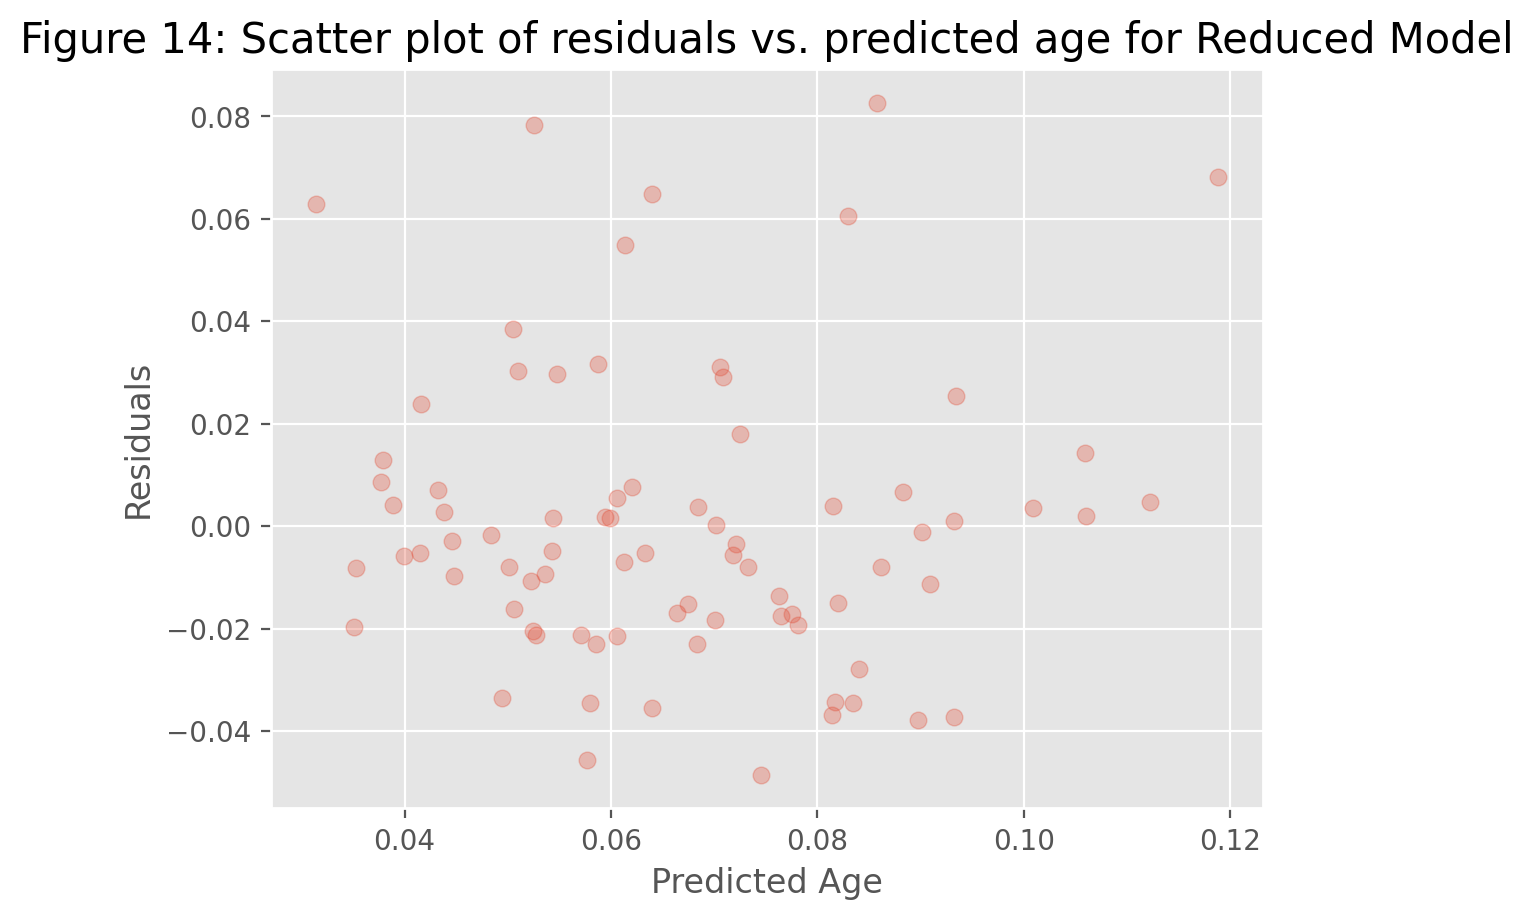

In [71]:
plt.scatter(pred[sec5.kwargs['selection']]['predicted'], pred[sec5.kwargs['selection']]['residual'], alpha=0.3);
plt.xlabel('Predicted Age');
plt.ylabel('Residuals')
plt.title('Figure 14: Scatter plot of residuals vs. predicted age for Reduced Model', fontsize=15)
plt.show();

Figure 14 looks very similar to Figure 10(a), suggesting that the
residuals exhibit the same banding pattern.

Let's now have look at the histogram of the residuals for the reduced
model.

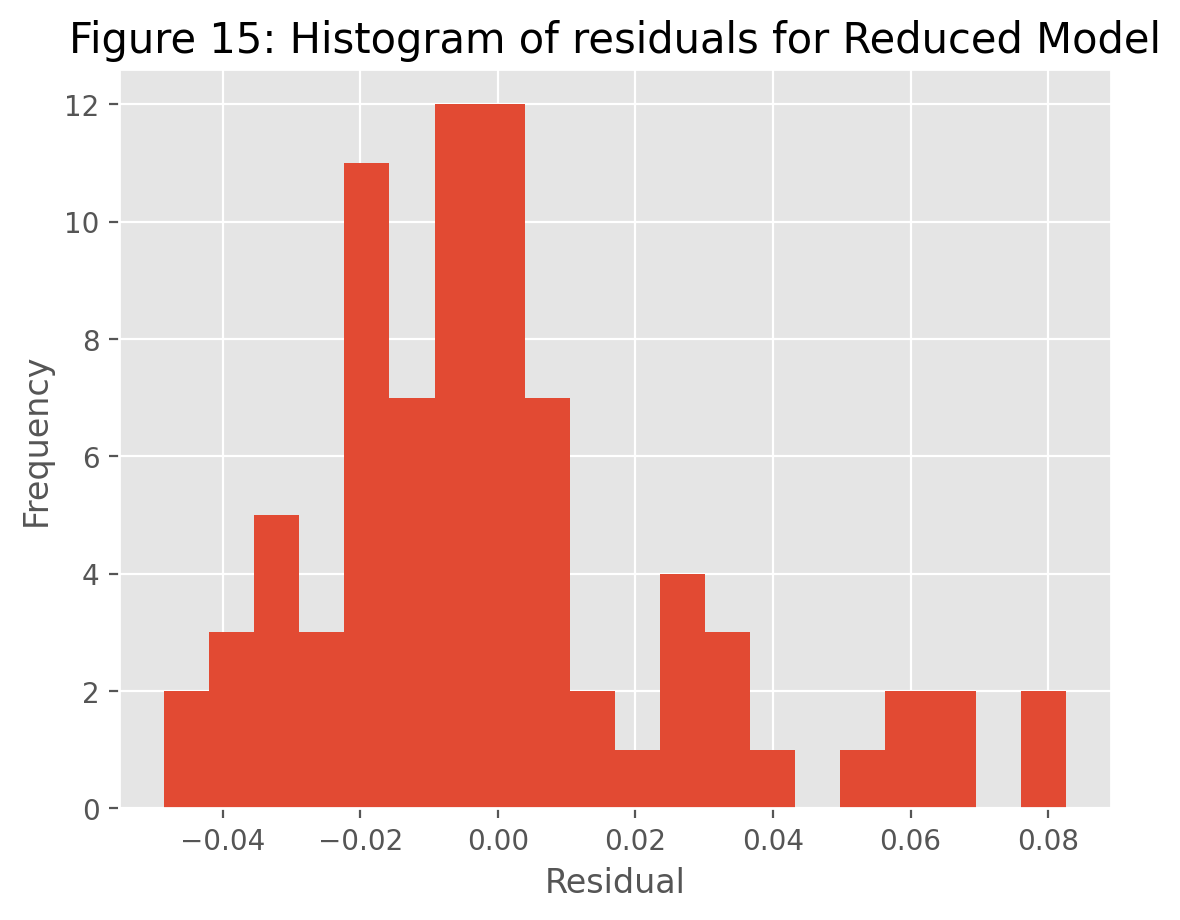

In [72]:
plt.hist(pred[sec5.kwargs['selection']]['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 15: Histogram of residuals for Reduced Model', fontsize = 15)
plt.show();

From Figure 15, there is again a somewhat symmetric histogram around
zero, which suggests that the residuals are somewhat normally
distributed.

## Summary and Conclusions<a href="#Summary-and-Conclusions" class="anchor-link"></a>

Using our independent variables, we were able to get a full model with
an Adjusted R-squared value of about 40%. After backwards variable
selection with a p-value cutoff value of 0.05, we were able to maintain
the same performance but with 6 less variables. Our final model has 49
variables all together with a model p-value of 0.

Diagnostic checks with residual scatter plots indicate that, rather than
being random and centered around 0, the residuals exhibit a banding
pattern, especially when predicted age is below 50. This pattern
indicates that the constant variability assumption of linear regression
is not quite satisfied in this case. On the other hand, residual
histograms suggest that there are no significant violations of the
normality assumption on the residuals.

The final multiple linear regression model has an Adjusted R-squared
value of about 40%, which is pretty low. So, it appears that the
variables we used are not quite adequate for accurately predicting the
age of an individual in the 1994 US Census dataset within a multiple
linear regression framework. A good next step might involve adding some
more interaction terms and maybe some other higher order terms to see if
this would result in some improvement for the Adjusted R-squared value.
Nonetheless, it might be the case that nonlinear models such as a neural
network might be more appropriate for the task at hand rather than a
linear regression model.

Our regression model appears to predict age correctly within \$\\pm40\$
years in general, though this is clearly a huge margin of error for the
model to be useful for any practical purposes. Furthermore, our model
has some rather significant issues. Specifically, our model consistently
overestimates younger ages and underestimates older ages. In particular,
for those younger than the age of 30, the model predicts much older
ages. Also, for those above the age of 80, the model predicts
significantly younger ages.

## References<a href="#References" class="anchor-link"></a>

-   Lichman, M. (2013). UCI Machine Learning Repository \[online\].
    Available at <https://archive.ics.uci.edu/ml/datasets/adult>
    \[Accessed 2022-10-07\]

***
featureranking.com